## Project 

This document is a modified version of project file used in Data 8 course of University of Berkeley. 

### Submission Deadline: 01 April 23:59

### Fill this file and submit it on uzak.etu system

You will build a classifier that guesses whether a song is hip-hop or country, using only the numbers of times words appear in the song's lyrics.  By the end of the project, you should know how to:

1. Build a k-nearest-neighbors classifier.
2. Test a classifier on data.
3. Evaluate different sets of features.

In [114]:
# Run this cell, but please don't change it.

import numpy as np
import math
import pandas as pd
%matplotlib inline

# 1. The Dataset

Our dataset is a table of songs, each with a name, an artist, and a genre.  For each song, we also know how frequently certain words occur in that song.  More precisely, we have a list of approximately 5000 words.  For each of these words, for each song, each item in the table describes the proportion of the song's lyrics that are the particular word.

For example, the lyrics of "In Your Eyes" is 168 words long. The word "like" appears twice:  $\frac{2}{168} \approx 0.0119$ of the words in the song. Similarly, the word "love" appears 10 times: $\frac{10}{168} \approx 0.0595$ of the words. Therefore, `lyrics.where("Title", "In Your Eyes").column("like").item(0)` is about $0.0119$, and `lyrics.where("Title", "In Your Eyes").column("love").item(0)` is about $0.0595$.

Our dataset doesn't contain all information about a song.  For example, it doesn't include the total number of words in each song, or information about the order of words in the song, let alone the melody, instruments, or rhythm. Nonetheless, you may find that word counts alone are sufficient to build an accurate genre classifier.

Run the cell below to read the `lyrics` table. **It may take up to a minute to load.**

In [115]:
# Just run this cell.
lyrics = pd.read_csv('lyrics_clean.csv')

# The first 5 rows of the table
lyrics.head(5)

,Title,Artist,Genre,i,the,you,to,and,a,me,...,writer,motivo,bake,insist,wel,santo,pe,gee,colleg,kad
0,Slicker Than Your Average,Craig David,Hip-hop,0.049536,0.017028,0.035604,0.020124,0.007740,0.006192,0.058824,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
1,Right There,MF Grimm,Hip-hop,0.037825,0.054374,0.023641,0.049645,0.009456,0.016548,0.018913,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
2,Talkin' All That,Cashis,Hip-hop,0.056738,0.049645,0.051418,0.010638,0.026596,0.033688,0.007092,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
3,It Only Hurts Me When I Cry,Raul Malo,Country,0.096491,0.074561,0.030702,0.017544,0.026316,0.017544,0.021930,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0
4,Is It Too Late Now,Lester Flatt & Earl Scruggs,Country,0.043902,0.000000,0.073171,0.019512,0.000000,0.014634,0.034146,...,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0


All titles are unique. The `row_for_title` function provides fast access to the one row for each title. 

In [116]:
#title_index = lyrics.index_by('Title')
def row_for_title(title):
    return lyrics[ lyrics["Title"] == title ].iloc[0] 
# to see an example
row_for_title("It Only Hurts Me When I Cry")

Title     It Only Hurts Me When I Cry
Artist                      Raul Malo
Genre                         Country
i                            0.096491
the                          0.074561
                     ...             
santo                             0.0
pe                                0.0
gee                               0.0
colleg                            0.0
kad                                 0
Name: 3, Length: 4979, dtype: object

This dataset was extracted from the Million Song Dataset (http://labrosa.ee.columbia.edu/millionsong/). Specifically, we are using the complementary datasets from musiXmatch (http://labrosa.ee.columbia.edu/millionsong/musixmatch) and Last.fm (http://labrosa.ee.columbia.edu/millionsong/lastfm).

The counts of common words in the lyrics for all of these songs are provided by the musiXmatch dataset (called a bag-of-words format). Only the top 5000 most common words are represented. For each song, we divided the number of occurrences of each word by the total number of word occurrences in the lyrics of that song.

The Last.fm dataset contains multiple tags for each song in the Million Song Dataset. Some of the tags are genre-related, such as "pop", "rock", "classic", etc.  To obtain our dataset, we first extracted songs with Last.fm tags that included the words "country", or "hip" and "hop". These songs were then cross-referenced with the musiXmatch dataset, and only songs with musixMatch lyrics were placed into our dataset. Finally, inappropriate words and songs with naughty titles were removed, leaving us with 4976 words in the vocabulary and 1726 songs.

## 1.1. Word Stemming
The columns other than Title, Artist, and Genre in the `lyrics` table are all words that appear in some of the songs in our dataset.  Some of those names have been *stemmed*, or abbreviated heuristically, in an attempt to make different [inflected](https://en.wikipedia.org/wiki/Inflection) forms of the same base word into the same string.  For example, the column "manag" is the sum of proportions of the words "manage", "manager", "managed", and "managerial" (and perhaps others) in each song.  

Stemming makes it a little tricky to search for the words you want to use, so we have provided another table that will let you see examples of unstemmed versions of each stemmed word.  Run the code below to load it.

**Question 1.1 [6 Points]** Stemming is normally a tricky operation. However,  we will do a simple operation for that. For a given word, first remove "s" at the end (if any).) 
Next, if the remaning part of the word ends with "er", remove it.
Next, if the remaning part of the word is longer than 5 letters, take the only first five letters.
Complete the function given below which returns stemmed version of a given word

In [117]:
# your answer should be here
def stemmer(word):
    if word[-1]=="s":
        word = word[0:-1]
    if word[-2::1] == "er":
        word = word[0:-2]
    if len(word) > 5:
        return word[:5]
    return word

**Question 1.2 [2 Points]** Run your stemmer function for the following words: yes, manager, hers, function and print their output. 

In [118]:
print("yes: ",stemmer("yes"))
print("manager: ",stemmer("manager"))
print("hers: ",stemmer("hers"))
print("function: ",stemmer("function"))

yes:  ye
manager:  manag
hers:  h
function:  funct


**Question 1.3 [4 Points]** Count the number of characters, the number of words, and the number of unique words in the "text.txt". To count the number of characters, you should count every character except  spaces, dots and commas. 

In [119]:
# your answer should be here
text = open("text.txt","r")
text = text.read()
words = text.split(" ")

for i in range(len(words)):
    if "." in words[i]:
        words[i] = words[i].replace('.', '')
    if "," in words[i]:
        words[i] = words[i].replace(',', '')
    if "\n" in words[i]:
        array = words[i].split("\n")
        words[i] = array[0]
        words.append(array[1])
        
character_length = 0
for i in words:
    character_length+=len(i)        

word_count = len(words)

unique_words = []
for i in words:
    if i not in unique_words:
        unique_words.append(i)
unique_word_count = len(unique_words)


print("The number of characters:\t", character_length, 
      "\nThe number of words:\t",word_count,
     "\nThe number of unique words:\t",unique_word_count,)

The number of characters:	 9968 
The number of words:	 1771 
The number of unique words:	 700


**Question 1.4 [4 Points]** Apply your stemmer function to every word in the document text.txt and print the number of characters of stemmed words, the number of stemmed words, and the number of unique stemmed words in the "text.txt". You should replace dots and commas with a space character.

In [120]:
#KONTROL ET!

text = open("text.txt","r")
text = text.read()
words = text.split(" ")

for i in range(len(words)):
    if "." in words[i]:
        words[i] = words[i].replace('.', '')
    if "," in words[i]:
        words[i] = words[i].replace(',', '')
    if "\n" in words[i]:
        array = words[i].split("\n")
        words[i] = array[0]
        words.append(array[1])
        

stem_words = []
for i in words:
    stem_words.append(stemmer(i))
    
character_length = 0
for i in stem_words:
    character_length+=len(i)

word_count = len(stem_words)

unique_words = []
for i in stem_words:
    if i not in unique_words:
        unique_words.append(i)
unique_word_count = len(unique_words)


print("The number of characters of stemmed words:\t", character_length, 
      "\nThe number of stemmed words:\t",word_count,
     "\nThe number of unique stemmed words:\t",unique_word_count,)

The number of characters of stemmed words:	 6936 
The number of stemmed words:	 1771 
The number of unique stemmed words:	 552


## 1.2. Splitting the dataset
We're going to use our `lyrics` dataset for three purposes.  First, we want to *train* various song genre classifiers.  Second, we want to *validate* which classifier is most effective. Finally, we want to *test* the performance of our final classifier. Hence, we need three different datasets: *training*, *validation*, and *test*.

The purpose of a classifier is to generalize to unseen data that is similar to the training data. Therefore, we must ensure that there are no songs that appear in two different sets. We do so by splitting the dataset randomly. The dataset has already been permuted randomly, so it's easy to split.  We just take the top for training, the next part for validation, and the last for test. 

Run the code below (without changing it) to separate the three datasets into tables.

In [121]:
# Here we have defined the proportion of our data
# that we want to designate for training as 10/16ths
# of our total dataset.  3/16ths of the data is
# reserved for validation.  The remaining 3/16ths
# will be used for testing.

training_proportion = 10/16
validation_proportion = 3/16
num_songs = lyrics.shape[0]

num_train = int(num_songs * training_proportion)
num_valid = int(num_songs * validation_proportion)
num_test = num_songs - num_train - num_valid

train_lyrics = lyrics.take(range(num_train))
valid_lyrics = lyrics.take(range(num_train, num_train + num_valid))
test_lyrics = lyrics.take(range(num_train + num_valid, num_songs))

print("Training: ",   train_lyrics.shape[0], ";",
      "Validation: ", valid_lyrics.shape[0], ";",
      "Test: ",       test_lyrics.shape[0])

Training:  1075 ; Validation:  322 ; Test:  324


**Question 1.2.1. [4 Points]** Draw a bar chart with three bars that shows the number of Hip-hop songs in each of the three datasets.

In [122]:
train_h = len(train_lyrics[train_lyrics["Genre"] == "Hip-hop"])
valid_h = len(valid_lyrics[valid_lyrics["Genre"] == "Hip-hop"])
test_h = len(test_lyrics[test_lyrics["Genre"] == "Hip-hop"])


<AxesSubplot:>

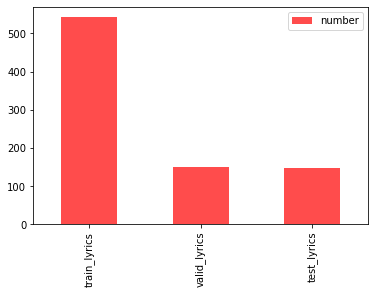

In [123]:
dFrame = pd.DataFrame({
    "number": [train_h,valid_h,test_h]
}, index = ["train_lyrics","valid_lyrics","test_lyrics"])
dFrame.plot.bar( color = "red", alpha = 0.7)

# 2. K-Nearest Neighbors - a Guided Example

K-Nearest Neighbors (k-NN) is a classification algorithm.  Given some *features* of an unseen example, it decides whether that example belongs to one or the other of two categories based on its similarity to previously seen examples.  

A feature we have about each song is *the proportion of times a particular word appears in the lyrics*, and the categories are two music genres: hip-hop and country.  The algorithm requires many previously seen examples for which both the features and categories are known: that's the `train_lyrics` table.

We're going to visualize the algorithm, instead of just describing it. To get started, let's pick colors for the genres.

In [124]:
# Just run this cell to define genre_color.

def genre_color(genre):
    """Assign a color to each genre."""
    if genre == 'Country':
        return 'gold'
    elif genre == 'Hip-hop':
        return 'blue'
    else:
        return 'green'

## 2.1. Classifying a  song

In k-NN, we classify a song by finding the `k` songs in the *training set* that are most similar according to the features we choose. We call those songs with similar features the "neighbors".  The k-NN algorithm assigns the song to the most common category among its `k` neighbors.

Let's limit ourselves to just 2 features for now, so we can plot each song.  The features we will use are the proportions of the words "like" and "love" in the lyrics.  Taking the song "In Your Eyes" (in the test set), 0.0119 of its words are "like" and 0.0595 are "love". This song appears in the test set, so let's imagine that we don't yet know its genre.

First, we need to make our notion of similarity more precise.  We will say that the *dissimilarity*, or *distance* between two songs is the straight-line distance between them when we plot their features in a scatter diagram. This distance is called the cosine distance.  

For example, in the song *Insane in the Brain* (in the training set), 0.0203 of all the words in the song are "like" and 0 are "love".  Its distance from *In Your Eyes* on this 2-word feature set is $1-\frac{((0.0119*0.0203) + (0.0595*0))}{ \sqrt{0.0119^2 +0.0595^2} * \sqrt{0.0203^2 + 0^2} } \approx 0.20$.  (If we included more or different features, the distance could be different.)


The function below creates a plot to display a test song and some training songs in a two-dimensional space defined by two features. As you can see in the result, *In Your Eyes* is more similar to *Sangria Wine* than to *Insane in the Brain*.

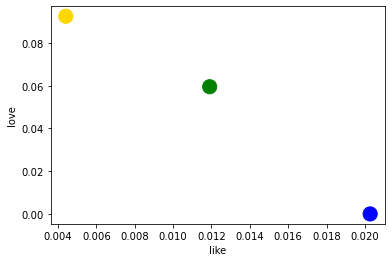

In [125]:
# Just run this cell.

def plot_with_two_features(test_song, training_songs, x_feature, y_feature):
    """Plot a test song and training songs using two features."""
    test_row = row_for_title(test_song)
    distances = pd.DataFrame({
            x_feature: [test_row[x_feature]],
            y_feature: [test_row[y_feature]],
            'Color':   [genre_color('Unknown')],
            'Title':   [test_song]
        }
    )
    i=1
    for song in training_songs:
        row = row_for_title(song)
        color = genre_color(row['Genre'])
        distances.loc[i] = [row[x_feature], row[y_feature], color, song]
        i = i+1
    
    distances.plot(x_feature, y_feature,kind="scatter",c="Color",s=200)
    
    
training = ["Sangria Wine", "Insane In The Brain"]
plot_with_two_features("In Your Eyes", training, "like", "love")

**Question 2.1.1. [4 Points]** Compute the Cosine distance between the two country songs, *Dixie Fried* and *Lonelier Than This* on the `['you', 'life','world',dream']` feature set

In [126]:
dixie_fried = row_for_title("Dixie Fried")
lonelier_than_this = row_for_title("Lonelier Than This")

p1 = dixie_fried["you"]*lonelier_than_this["you"]
p2 = dixie_fried["life"]*lonelier_than_this["life"]
p3 = dixie_fried["world"]*lonelier_than_this["world"]
p4 = dixie_fried["dream"]*lonelier_than_this["dream"]

pa1 = (dixie_fried["you"]**2 + dixie_fried["life"]**2 + dixie_fried["world"]**2 + dixie_fried["dream"]**2)
pa2 = (lonelier_than_this["you"]**2+lonelier_than_this["life"]**2+lonelier_than_this["world"]**2+lonelier_than_this["dream"]**2)
country_distance = 1 - ((p1+p2+p3+p4)/((math.sqrt(pa1))*(math.sqrt(pa2))))

country_distance

0.2928932188134524

**Question 2.1.2. [4 Points]** Complete the function `distance_four_features` that computes the Cosine distance between any two songs, using four features. The last two lines call the `distance_four_features` function  to show that *Lookin' for Love* is closer to *In Your Eyes* than *Insane In The Brain*. 

In [127]:
def distance_four_features(title0, title1, x1_feature, x2_feature,x3_feature,x4_feature):
    title0 = row_for_title(title0)
    title1 = row_for_title(title1)
        
    p1 = title0[x1_feature]*title1[x1_feature]
    p2 = title0[x2_feature]*title1[x2_feature]
    p3 = title0[x3_feature]*title1[x3_feature]
    p4 = title0[x4_feature]*title1[x4_feature]
    
    pa1 = (title0[x1_feature]**2 + title0[x2_feature]**2 + title0[x3_feature]**2 + title0[x4_feature]**2)
    pa2 = (title1[x1_feature]**2+title1[x2_feature]**2+title1[x3_feature]**2+title1[x4_feature]**2)
    
    return (1 - ((p1+p2+p3+p4)/((pa1*pa2)**0.5)))

for song in ["Lookin' for Love", "Insane In The Brain"]:
    song_distance = distance_four_features(song, "In Your Eyes", "you", "life","world","dream")
    print(song, 'distance:\t', song_distance)

Lookin' for Love distance:	 0.15484574932822492
Insane In The Brain distance:	 0.057091941076588215


The nearest neighbor to a song is the example in the training set that has the smallest distance from that song.

**Question 2.1.3. [4 Points]** Define the higher-order function `distance_from` that takes a single song title and two features. It returns a function `for_song` that takes a second song title and computes the distance between the first and second songs.

*Hint: Call `distance_two_features` in your solution rather than re-implementing its computation.*

In [128]:
def distance_from(title0, x1_feature, x2_feature,x3_feature,x4_feature):
    def for_song(title1):
        return distance_four_features(title0, title1, x1_feature, x2_feature,x3_feature,x4_feature)
    return for_song

distance_from_in_your_eyes = distance_from("In Your Eyes", "you", "life","world","dream")
distance_from_in_your_eyes("Lookin' for Love")

0.15484574932822492

**Question 2.1.4. [6 Points]**  What are the names and genres of the 7 closest songs to "You're Just a Country Boy" in  `train_lyrics`, by Cosine distance for the 4 features "you", "life","world", and "dream"?  To answer this question, make a table named `closest_songs` containing those 7 songs with columns "Title", "Artist", "Genre", "you", "life","world", and "dream" from the `lyrics` table, as well as a column called `cosine_distance` that contains the distance from "Raul Malo" **sorted in ascending order**.

In [129]:
"""raulMaloSong = like_love[like_love["Artist"] == "Raul Malo"]["Title"][3]""" #Raul Malo's song in train_lyrics"""
def tempFunc(i):
    t = distance_from("You're Just a Country Boy", "you", "life","world","dream")
    return t(i)
   

lyrics["cosine_distance"] = lyrics["Title"].apply(lambda x: tempFunc(x))
temp = lyrics.sort_values("cosine_distance", ascending = True)


In [130]:
temp = temp[["Title", "Artist", "Genre", "you", "life","world",  "dream", "cosine_distance"]]
closest_songs =temp.head(7)
closest_songs

,Title,Artist,Genre,you,life,world,dream,cosine_distance
860,Let Her In,Vince Gill,Country,0.044248,0.0,0.0,0.0,-2.220446e-16
1087,Every Time You Say Goodbye,Alison Krauss & Union Station,Country,0.038278,0.0,0.0,0.0,-2.220446e-16
569,Two-Step 'Round The Christmas Tree,Suzy Bogguss,Country,0.011719,0.0,0.0,0.0,-2.220446e-16
753,Still Tippin,Slim Thug,Hip-hop,0.005405,0.0,0.0,0.0,-2.220446e-16
566,I Will Follow You Into The Dark (Live Death Ca...,Amy Millan,Country,0.044248,0.0,0.0,0.0,-2.220446e-16
405,Make-Up,Amanda Blank,Hip-hop,0.046875,0.0,0.0,0.0,-2.220446e-16
1555,Give It To You,G. Love,Hip-hop,0.083871,0.0,0.0,0.0,-2.220446e-16


**Question 2.1.5. [6 Points]** Write a function `most_common` that takes a `column_label` and a `table`. It returns the most common value in that column of that table. In case of a tie, it can return any of the most common values.

In [131]:
def most_common(column_label, table):
    return table[column_label].mode()[0]
most_common('Genre', closest_songs)

'Country'

Congratulations are in order -- you've classified your first song!

# 3. Features

Now, we're going to extend our classifier to consider more than four features at a time.

**Question 3.1. [4 Points]** Write a function to compute the Cosine distance between two *arrays* of features of *arbitrary* (but equal) length.  Use it to compute the distance between the first song in the training set and the first song in the test set, *using all of the features*.  (Remember that the title, artist, and genre of the songs are not features.)

In [132]:
def distance(features1, features2):
    sumxx, sumxy, sumyy = 0, 0, 0
    for i in range(len(features1)):
        x = features1[i]; y = features2[i];
        sumxx += x*x
        sumyy += y*y
        sumxy += x*y
    return sumxy/math.sqrt(sumxx*sumyy) 

train_features = train_lyrics.drop(["Artist","Title","Genre"], axis =1).iloc[0].array
test_features = test_lyrics.drop(["Artist","Title","Genre"], axis =1).iloc[0].array

distance_first_to_first = distance(train_features,test_features)
distance_first_to_first

0.4964655394894052

## 3.1. Creating your own feature set

Unfortunately, using all of the features has some downsides.  We'll explore that more later, but one clear downside is *computational* -- computing Cosine distances just takes a long time when we have lots of features.  So we're going to select just 25 for now.  We'd like to choose features that are very *discriminative*, that is, which lead us to correctly classify as much of the test set as possible.  This process of choosing features that will make a classifier work well is sometimes called *feature selection*, or more broadly *feature engineering*.

**Question 3.1.1. [4 Points]** Look through the list of features (the labels of the `lyrics` table after the first three).  Choose 25 that you think will let you distinguish pretty well between country and hip-hop songs.  You might want to come back to this question later to improve your list, once you've seen how to evaluate your classifier.  The first time you do this question, spend some time looking through the features, but not more than 15 minutes.

In [133]:
lyrics = lyrics.drop(["cosine_distance"],axis = 1)
lyrics.columns

Index(['Title', 'Artist', 'Genre', 'i', 'the', 'you', 'to', 'and', 'a', 'me',
       ...
       'writer', 'motivo', 'bake', 'insist', 'wel', 'santo', 'pe', 'gee',
       'colleg', 'kad'],
      dtype='object', length=4979)

In [134]:
# Set my_25_features to a list of 25 features (strings that are column labels)
def insertionSort(arr):
     for i in range(1, len(arr)):
        key = arr[i]
        j = i-1
        while j >= 0 and key[1] < arr[j][1] :
                arr[j + 1] = arr[j]
                j -= 1
        arr[j + 1] = key
        
col = lyrics.columns
tempFreq = []
tempDf = lyrics.groupby("Genre").sum()
k = 0
j = 0
for i in col[3:]:
    if len(tempFreq) < 25:
        tempFreq.append([i,abs(tempDf[i][0]-tempDf[i][1])])
    if (tempDf[i][0] == 0 or tempDf[i][1] == 0):
        j+=1
        continue
    k+=1
    temp = abs(tempDf[i][0]-tempDf[i][1])
    insertionSort(tempFreq)
    if len(tempFreq) >= 25:
        for j in range(25):
            if temp > tempFreq[j][1]:
                tempFreq[j] = [i,temp]
                break 

my_25_features = []
for i in tempFreq:
    my_25_features.append(i[0])
    
train_25 = train_lyrics[my_25_features]
test_25 = test_lyrics[my_25_features]

**Question 3.1.2 [4 Points]** In a few sentences, describe how you selected your features. 

**Answer : I chose these features according to the difference in the amount of usage in country and hip-hop.**

Next, let's classify the first song from our test set using these features.  You can examine the song by running the cells below. Do you think it will be classified correctly?

In [135]:
test_lyrics.iloc[0][['Title', 'Artist', 'Genre']]

Title     Put 'Em On The Glass
Artist           Sir Mix-A-Lot
Genre                  Hip-hop
Name: 1397, dtype: object

**Question 3.1.3 [6 Points]**  As before, we want to look for the songs in the training set that are most alike our test song.  We will calculate the Cosine distances from the test song (using the 25 selected features) to all songs in the training set. Define `distances` function to do this. 

In [136]:
import warnings
warnings.filterwarnings("ignore")

def distance_features(title0, title1, feature_list):
    title0 = row_for_title(title0)
    title1 = row_for_title(title1)
    
    pay = 0
    payda1 = 0
    payda2 = 0
    
    for i in feature_list:
        pay+=title0[i]*title1[i]
        payda1+=title0[i]**2
        payda2+=title1[i]**2
        
    return (1 - (pay/((payda1*payda2)**0.5))) 


def distances(test_row, train_rows):
    distances = []
    for j in train_rows:
            distances.append(distance_features(test_row,j,my_25_features))
    return pd.DataFrame({
        "Title" : train_rows,
        "Distances" : distances
    })
    

**Question 3.1.4. [6 Points]** Use the `distances` function provided above to compute the distance of the first song in the test set to all the songs in the training set.  Make a new table called `genre_and_distances` with one row for each song in the training set and two columns:
* The `"Genre"` of the training song
* The `"Distance"` from the first song in the test set 

Ensure that `genre_and_distances` is **sorted by increasing distance to the first test song**.

In [178]:
temp = distances(test_lyrics["Title"].values[0], train_lyrics["Title"].values)
temp["Genre"] = train_lyrics["Genre"].values
genre_and_distances = temp.sort_values("Distances").set_index("Title")
      
genre_and_distances = genre_and_distances.fillna(0)
genre_and_distances

,Distances,Genre
Title,,
Bring The Pain,0.022775,Hip-hop
In The Oaktown,0.028187,Hip-hop
Showtime At The Gallow,0.028715,Hip-hop
Testarossa,0.028818,Hip-hop
Show Me What You Got,0.028993,Hip-hop
...,...,...
Entre les mots : du local au global,1.000000,Hip-hop
Regarde,1.000000,Hip-hop
Playing With Fire,0.000000,Country


**Question 3.1.5. [8 Points]**  Now compute the 7-nearest neighbors classification of the second song in the test set.  That is, decide on its genre by finding the most common genre among its 7 nearest neighbors, according to the distances you've calculated.  Then check whether your classifier chose the right genre.  (Depending on the features you chose, your classifier might not get this song right, and that's okay.)

In [140]:
temp2 = distances(test_lyrics["Title"].values[1], train_lyrics["Title"].values)
temp2["Genre"] = train_lyrics["Genre"]
temp2 = temp2.sort_values("Distances")
seven_neighbors = temp2.set_index("Title").head(7)
seven_neighbors

,Distances,Genre
Title,,
Kick A Little (Album Version),0.074628,Country
Baby Mine,0.077776,Country
Waiting,0.086178,Hip-hop
Naked In The Rain,0.093946,Country
Dip It Low,0.102532,Hip-hop
The World,0.113977,Country
Stand!,0.119889,Hip-hop


In [141]:
my_assigned_genre = seven_neighbors["Genre"].mode()[0]
my_assigned_genre_was_correct = my_assigned_genre==test_lyrics["Genre"].iloc[1]
print("The assigned genre", my_assigned_genre, "was correct...", my_assigned_genre_was_correct )

The assigned genre Country was correct... True


In [142]:
if seven_neighbors["Genre"].mode()[0] == test_lyrics["Genre"].values[1]:
    print("Classifier found the genre correctly!")
else:
    print("Classifier found the genre incorrectly!")

Classifier found the genre correctly!


## 3.2. A classifier function

Now it's time to write a single function that encapsulates this whole process of classification.

**Question 3.2.1. [8 Points]** Write a function called `classify`.  It should take the following arguments:
* An array of features for a song to classify (e.g., `test_25.row(0)`),
* A table with a column for each feature (for example, `train_25`)
* An array of classes that has as many items as the previous table has rows, and in the same order, and
* `k`, the number of neighbors to use in classification.

It should return the class your classifier picks for the given row of features (e.g., `'Country'` or `'Hip-hop'`). 

In [184]:
#Sor. Bizim classify test tablosu, train tablosu, features 
def classify(test_row, train_rows, train_classes, k):
    Genre = train_rows["Genre"]
    test_row = test_row[train_classes]
    train_rows = train_rows[train_classes]
    test_values = test_row.values
    dist = []
    
    for i in range(train_rows.shape[0]):
        train_values = train_rows.iloc[i].values
        pay = 0
        payda1 = 0
        payda2 = 0

        for j in range(len(train_classes)):
            pay+=test_values[j]*train_values[j] 
            payda1+=test_values[j]**2
            payda2+=train_values[j]**2
        dist.append((1 - (pay/((payda1*payda2)**0.5))))
        
    temp_df =  pd.DataFrame({
        "Distances" : dist,
        "Genre" : Genre
    })
    temp_df = temp_df.sort_values("Distances")
    return temp_df.head(k)["Genre"].mode()[0]
    

In [185]:
classify(test_lyrics.iloc[1],train_lyrics,my_25_features,7)

'Country'

**Question 3.2.2. [4 Points]** Assign `guitar_genre` to the genre predicted by your classifier for the song  "Guitar Town" in the test set, using 7 neigbors.

In [145]:
#Kontrol Et çünkü orijinali Country 
temp_test_lyrics = test_lyrics.set_index("Title")
guitar_genre = classify(temp_test_lyrics.loc["Guitar Town"],train_lyrics,my_25_features,7)
guitar_genre

'Hip-hop'

**Question 3.2.3 [6 Points]** To simplify things further, use the higher-order function `classify_using` that takes `train_rows`, `train_classes`, and `k` to define a function `simple_classify`. The `simple_classify` function should take just one argument, a test row, and return the predicted genre of a song using `train_25` and seven neighbors (`k` of 7).  This way, when we classify a song, we just have to pass in the song's features, not the whole training set.  

In [146]:
def classify_using(train_rows, train_classes, k):
    def for_row(test_row):
        return classify(test_row, train_rows, train_classes, k)
    return for_row

def simple_classify(test_row):
    classifer = classify_using(train_lyrics,my_25_features,7)
    return classifer(test_row)
    

simple_classify(test_25.iloc[0])

'Hip-hop'

## 3.3. Evaluating your classifier

Now that it's easy to use the classifier, let's see how accurate it is on the whole test set.

**Question 3.3.1. [8 Points]** Classify every song in the test set (provided), then compute the proportion of correct classifications. 

In [147]:
classified = []
for i in range(test_lyrics.shape[0]):
    classified.append(simple_classify(test_lyrics.iloc[i]))
    

test_lyrics["Classified"] = classified



In [155]:
num = 0
for i in range(test_lyrics.shape[0]):
    if test_lyrics["Genre"].values[i] == test_lyrics["Classified"].values[i]:
        num+=1

test_lyrics = test_lyrics.drop("Classified",axis = 1)
proportion_correct = num/test_lyrics.shape[0]
proportion_correct

0.6820987654320988

At this point, you've gone through one cycle of classifier design.  Let's summarize the steps:
1. From available data, select test and training sets.
2. Choose an algorithm you're going to use for classification.
3. Identify some features.
4. Define a classifier function using your features and the training set.
5. Evaluate its performance (the proportion of correct classifications) on the test set.

In practice, if the performance is good enough for your application, you might be done. In this case, we might be able to do better by focusing on step 3.

# 4. Feature design

One way to interpret the accuracy of a classifier is to compare it to another classifier.

**Question 4.1. [10 Points]** Below we've provided 10 features selected by the staff.  Build a 11-nearest-neighbor classifier using these features and compute its accuracy on the test set. (You can write any code you want, as long as `proportion_correct_staff` is computed correctly; the other names are only suggestions.)

In [157]:
features_staff = ["come", "do", "love", "like", "make", "never", "now", "wanna", "with", "yo"]

def classify_using(train_rows, features, k):
    def for_row(test_row):
        return classify(test_row, train_rows, features, k)
    return for_row

def simple_classify2(test_row):
    classifer = classify_using(train_lyrics,features_staff,11)
    return classifer(test_row)

classified = []
for i in range(test_lyrics.shape[0]):
    classified.append(simple_classify2(test_lyrics.iloc[i]))
    

test_lyrics["Classified"] = classified

num = 0
for i in range(test_lyrics.shape[0]):
    if test_lyrics["Genre"].values[i] == test_lyrics["Classified"].values[i]:
        num+=1

proportion_correct_staff = num/test_lyrics.shape[0]
proportion_correct_staff

0.6666666666666666

**Question 4.2. [4 Points]** Are the features you chose better or worse than the staff features at classifying the test set? Why do you think this is so?

**Answer : The features I chose have slightly better accuracy values.**

**Question 4.3. [6 Points]** Is there anything random about a classifier's accuracy measured in this way?  Is it possible that the difference in classifier performance is due to chance?  If so, describe (in 2-3 sentences) how you would investigate that.

**Answer : Random generation of Train and Test tables is the only factor that creates randomness. If the Test and Train tables are also randomly generated many times and the accuracy value is calculated, the result will be within a confidence interval. So randomness has an effect, but it's very low.**

## 4.1. Feature selection

What happens if we use only use a subset of the staff features? Is there a single feature that's better than the rest? Can removing features improve our classifier? Does removing features always hurt? If so, does removing different features degrade accuracy by different amounts?

As soon as you begin comparing the performance of many different classifiers, searching for the best one, it is important to conduct that search on the *validation set* rather than the *test set*. Conventionally, the test set is used for evaluation of methods. The validation set is used to select exactly how a method is applied, such as choosing a set of features or a value for `k`.  The validation set is called `valid_lyrics`.

**Question 4.1.1. [8 Points]** Define a higher-order function `accuracy_on` that takes an evaluation set, either `valid_lyrics` or `test_lyrics`. It returns a function that takes a feature list and a value for `k`, and returns the accuracy (proprotion correct) of a `k`-NN classifier on the evaluation set using those features.

In [161]:
def accuracy_on(evaluation_set):
    def accuracy(features, k):
        classified = []
        for i in range(evaluation_set.shape[0]):
            classified.append(classify(evaluation_set.iloc[i], train_lyrics, features, k))

        evaluation_set["Classified"] = classified

        num = 0
        for i in range(evaluation_set.shape[0]):
            if evaluation_set["Genre"].values[i] == test_lyrics["Classified"].values[i]:
                num+=1
        return num/evaluation_set.shape[0]
    return accuracy

valid_accuracy = accuracy_on(valid_lyrics)
valid_accuracy(features_staff, 5)

0.515527950310559

**Question 4.1.2.[6 Points]** Create a two-column table `single_feature_accuracies` that shows the accuracy on the validation set using 7 neighbors and only a single feature. Include a row for every feature in `features_staff`.

In [192]:
def temp_classify(test_row, train_rows, train_classes, k):
    Genre = train_rows["Genre"]
    test_row = test_row[train_classes]
    train_rows = train_rows[train_classes]
    test_value = test_row
    dist = []
    for i in range(train_rows.shape[0]):
        train_value = train_rows.iloc[i]
        pay=test_value*train_value
        payda1=test_value**2
        payda2=train_value**2
        dist.append((1 - (pay/((payda1*payda2)**0.5))))       
    temp_df =  pd.DataFrame({
        "Distances" : dist,
        "Genre" : Genre
    })
    
    temp_df = temp_df.sort_values("Distances")
    return temp_df.head(k)["Genre"].mode()[0]

acc = []
for f in features_staff:
    classified = []
    for j in range(valid_lyrics.shape[0]):
        classified.append(temp_classify(valid_lyrics.iloc[j],train_lyrics,f,7))
    valid_lyrics["Classified"] = classified
    num = 0
    for i in range(valid_lyrics.shape[0]):
        if valid_lyrics["Genre"].values[i] == valid_lyrics["Classified"].values[i]:
            num+=1
    acc.append(num/valid_lyrics.shape[0])   
    
valid_lyrics = valid_lyrics.drop("Classified",axis=1)
single_feature_accuracies = pd.DataFrame({"features_staff":features_staff})
single_feature_accuracies["accuracy"] = acc
single_feature_accuracies = single_feature_accuracies.sort_values(by = "accuracy", ascending = True)
single_feature_accuracies

,features_staff,accuracy
2,love,0.468944
5,never,0.555901
1,do,0.565217
8,with,0.571429
0,come,0.574534
3,like,0.590062
6,now,0.590062
4,make,0.633540
7,wanna,0.667702
9,yo,0.689441


An *ablation* study involves attempting to determine which features matter most for classification accuracy by removing ("ablating") each of them individually.

**Question 4.1.3. [6 Points]** Create a two-column table `ablation_accuracies` that shows the accuracy on the validation set of a 7-NN classifier that has all `features_staff` except one. Include a row for every feature in `features_staff` that you leave out. (*Hint*: Lists have a `.remove` method that takes the element to be removed.)

In [187]:
ablation_accuracies = pd.DataFrame({"Feature":features_staff})
acc = []
for f in features_staff:
    features = list(features_staff) 
    features.remove(f)  
    classified = []
    for j in range(valid_lyrics.shape[0]):
        classified.append(classify(valid_lyrics.iloc[j],train_lyrics,features,7))
    valid_lyrics["Classified"] = classified
    num = 0
    for i in range(valid_lyrics.shape[0]):
        if valid_lyrics["Genre"].values[i] == valid_lyrics["Classified"].values[i]:
            num+=1
    acc.append(num/valid_lyrics.shape[0])   
    
    
ablation_accuracies["All-Except-One Accuracy"] = acc
ablation_accuracies = ablation_accuracies.sort_values("All-Except-One Accuracy")
ablation_accuracies

,Feature,All-Except-One Accuracy
9,yo,0.652174
1,do,0.677019
2,love,0.677019
6,now,0.680124
4,make,0.689441
5,never,0.689441
0,come,0.704969
7,wanna,0.708075
3,like,0.714286
8,with,0.720497


**Question 4.1.5. [8 Points]** Draw a scatter diagram with one dot for every **odd** value of `k` from 1 to 15 (inclusive) that plots the accuracy on the validation set on the horizontal axis and accuracy on the test set on the vertical axis. Use `features_staff` as the features for all points.

In [196]:
k = [1,3,5,7,9,11,13,15]
df = pd.DataFrame({"k": k})
acc_test = []
acc_valid = []
for k_value in k:
    classified_test = []
    classified_valid = []
    
    for j in range(valid_lyrics.shape[0]):
        classified_valid.append(classify(valid_lyrics.iloc[j],train_lyrics,features_staff,k_value))
    valid_lyrics["Classified"] = classified_valid
    num = 0
    for i in range(valid_lyrics.shape[0]):
        if valid_lyrics["Genre"].values[i] == valid_lyrics["Classified"].values[i]:
            num+=1
            
    acc_valid.append(num/valid_lyrics.shape[0])
    
    
    for j in range(test_lyrics.shape[0]):
        classified_test.append(classify(test_lyrics.iloc[j],train_lyrics,features_staff,k_value))
    test_lyrics["Classified"] = classified_test
    num = 0
    for i in range(test_lyrics.shape[0]):
        if test_lyrics["Genre"].values[i] == test_lyrics["Classified"].values[i]:
            num+=1
            
    acc_test.append(num/test_lyrics.shape[0])
    
    valid_lyrics = valid_lyrics.drop("Classified",axis=1)
    test_lyrics = test_lyrics.drop("Classified",axis=1)
    

df["Test Lyrics"] = acc_test
df["Valid Lyrics"] = acc_valid

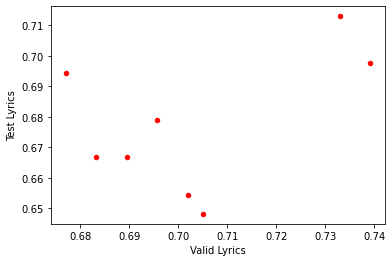

In [201]:
k = df.plot.scatter("Valid Lyrics","Test Lyrics",c ="red")

Congratulations! You're done with the project.